### Goal:
Based on provided Smiles string, get the blood-brain barrier penetration prediction from different models available through OpenRiskNet service (Lazar, CPSign)

#### Load libraries

In [1]:
from pip._internal import main as pip

import dst

try:
    import requests
except ImportError:
    pip(['install', 'request'])
    import requests

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import numpy as np
except ImportError:
    pip(['install', 'numpy'])
    import numpy as np
    
try:
    import json
except ImportError:
    pip(['install', 'json'])
    import json
    
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt
    
    
try:
    import pprint
except ImportError:
    pip(['install', 'pprint'])
    import pprint

#### Define which models are used (and set their PPV, NPV values)

In [2]:
# define models used
models = ['CPSign', 'Lazar']

# initiate dictionaries to collect model properties/predictions
models_pred, models_prob, models_ppv, models_npv = {}, {}, {}, {}

models_npv['CPSign'] = 0.701
models_npv['Lazar'] = 0.489

models_ppv['CPSign'] = 0.809
models_ppv['Lazar'] = 0.886

#### User enters Smiles string

In [4]:
smiles = input()

 OOCCOO


#### Lazar model

In [5]:
# parameters to access API
url = 'https://lazar.prod.openrisknet.org/model/5ae2dd885f1c2d01323270ee'
body = {'identifier': smiles}
headers = {'accept': 'text/csv'}

r = requests.post(url, headers=headers, data=body)

if r.status_code == 200:
    result = json.loads(r.text)
   
    try:
        pred = result['prediction']['value']
        
        if pred == None:
            pass
        elif pred == 'penetrating':
            pred = 'P'
        else:
            pred = 'N'
        
        # these probabilities could be used in DST approach, but currently we assume that predicted class has probability 1
        prob_p = result['prediction']['probabilities']['penetrating']
        prob_n = result['prediction']['probabilities']['non-penetrating']
        
    except KeyError:
        print('Prediction could not be made')
        pred, prob_p, prob_n = None, None, None
        
    models_pred['Lazar'] = pred
    models_prob['Lazar'] = 1.  # we assign probability 1 to the predicted class
else:
    print('Error in accessing LAZAR web service.')

Prediction could not be made


#### CPSign model

In [6]:
url = "http://blood-brain-barrier-penetration-cvap-cpsign.prod.openrisknet.org/v1/predict"
body = {'molecule': smiles}
headers = {'accept': 'application/json'}

r = requests.get(url, headers=headers, params=body)

if r.status_code == 200:
    result = json.loads(r.text)
    
    result = pd.DataFrame(result['prediction']).set_index('label')
    
    prob_p = result.loc['penetrating', 'probability']
    prob_n = result.loc['non-penetrating', 'probability']
    
    if prob_p > prob_n:
        models_pred['CPSign'] = 'P'
        models_prob['CPSign'] = prob_p
    else:
        models_pred['CPSign'] = 'N'
        models_prob['CPSign'] = prob_n
    
else:
    print('Error in accessing CPSign web service.')

Error in accessing CPSign web service.


#### Results of individual predictive models collected in dictionaries

In [221]:
print('models_pred:\n', models_pred, '\n\nmodels_prob:\n', models_prob, '\n\nmodels_ppv:\n', models_ppv, '\n\nmodels_npv:\n', models_npv)

models_pred:
 {'Lazar': None, 'CPSign': 'P'} 

models_prob:
 {'Lazar': 1.0, 'CPSign': 0.966} 

models_ppv:
 {'CPSign': 0.809, 'Lazar': 0.886} 

models_npv:
 {'CPSign': 0.701, 'Lazar': 0.489}


#### Consensus predictions

In [224]:
# if all models have valid predictions, then continue with consensus
validPred = True
for model in models:
    if (models_pred[model] == 'P') or (models_pred[model] == 'N'):
        pass
    else:
        validPred = False
        
if validPred:
    bel, pls, res = {}, {}, {}

    # Dempster rule
    bel['D'], pls['D'], res['D'] = dst.predict_Dempster(models_pred, models_prob, models_ppv, models_npv)

    # Yager rule
    bel['Y'], pls['Y'], res['Y'] = dst.predict_Yager(models_pred, models_prob, models_ppv, models_npv)
else:
    print('Some prediction is invalid.')

Some prediction is invalid.


#### Visualization of predictions

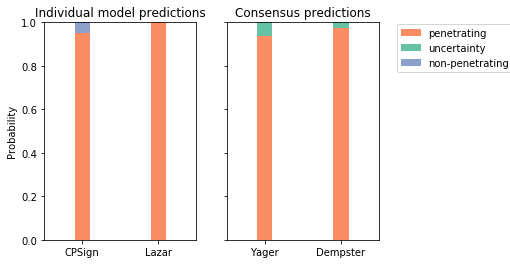

In [204]:
colorPenetrating = '#fc8d62'
colorNonpenetrating = '#8da0cb'
colorUncertainty = '#66c2a5'

def color_prediction(state):
    if state == 'P':
        return colorPenetrating
    else:
        return colorNonpenetrating
    
def color_antiprediction(state):
    if state == 'P':
        return colorNonpenetrating
    else:
        return colorPenetrating

fig, axs = plt.subplots(1, 2)

width = 0.2

# left plot - individual models
for i in range(len(models)):
    axs[0].bar(i, models_prob[models[i]], width, bottom=0, color=color_prediction(models_pred[models[i]]) )
    axs[0].bar(i, (1 - models_prob[models[i]]), width, bottom=models_prob[models[i]], color=color_antiprediction(models_pred[models[i]]))
    
axs[0].set_xticks(range(len(models)))    
axs[0].set_xticklabels(models)
axs[0].set_xlim(-0.5, len(models) - 0.5)
axs[0].set_ylabel('Probability')
axs[0].set_ylim(0, 1)
axs[0].set_title('Individual model predictions')

# right plot - consensus models
axs[1].bar(0, bel['Y']['P'], width, bottom=0, color=colorPenetrating)
axs[1].bar(0, (pls['Y']['P'] - bel['Y']['P']), width, bottom=bel['Y']['P'], color=colorUncertainty)
axs[1].bar(0, bel['Y']['N'], width, bottom=pls['Y']['P'], color=colorNonpenetrating)

p1 = axs[1].bar(1, bel['D']['P'], width, bottom=0, color=colorPenetrating)
p2 = axs[1].bar(1, (pls['D']['P'] - bel['D']['P']), width, bottom=bel['D']['P'], color=colorUncertainty)
p3 = axs[1].bar(1, bel['D']['N'], width, bottom=pls['D']['P'], color=colorNonpenetrating)

axs[1].set_xticks([0, 1])    
axs[1].set_xticklabels(['Yager', 'Dempster'])
axs[1].set_xlim(-0.5, len(models) - 0.5)
axs[1].set_ylabel('')
axs[1].set_yticklabels('')
axs[1].set_ylim(0, 1)
axs[1].set_title('Consensus predictions')

fig.legend((p1[0], p2[0], p3[0]), ('penetrating', 'uncertainty', 'non-penetrating'), bbox_to_anchor=(1.2, 0.85))

fig.show()